In [294]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import accuracy_score as acc

# Classifiers / pre-processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import spacy

In [199]:
df = pd.read_csv("./quora_duplicate_questions.tsv", sep='\t', encoding='utf-8')
df = df[~df.question1.isnull() & ~df.question2.isnull() & ~df.is_duplicate.isnull()]
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


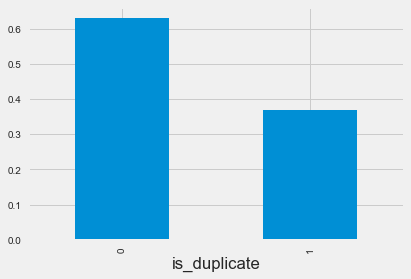

In [43]:
%matplotlib inline
mpl.style.use('fivethirtyeight')
plt.xlabel("is_duplicate")
(df.is_duplicate.value_counts() / df.is_duplicate.value_counts().sum()).plot(kind='bar')

In [44]:
nlp = spacy.load("en")

## Base models settings
---
### TF-IDF configuration:
- grams: unigrams, bigrams
- binary: false (so far)

In [51]:
tfidf = TfidfVectorizer(ngram_range=(1, 2)).fit(pd.concat([df.question1, df.question2]))
X = tfidf.transform(df.question1) - tfidf.transform(df.question2) # diff matrix

### LinearSVM

In [233]:
y = df.is_duplicate
cut = int(X.shape[0] * .8)
X_train, y_train = X[:cut], y[:cut]
X_test, y_test = X[cut:], y[cut:]
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
p, r, f, _ = prfs(y_test, y_pred, average='weighted')
print "LinearSVM performance on 80/20 split w/ TFIDF"
print "%.2f\t%.2f\t%.2f" % (p, r, f)
print "acc: %.2f" % acc(y_test, y_pred)

LinearSVM performance on 80/20 split w/ TFIDF
0.65	0.64	0.65
acc: 0.64


In [234]:
# Code below commented for "safety"
# It takes a while to run - did not measure, but roughly 35-40min
# Should not be needed to re-run unless some major change was applied

def question2vec(question):
    return nlp(question).vector

# X_question1 = np.array(df.question1.apply(question2vec).tolist())
# X_question2 = np.array(df.question2.apply(question2vec).tolist())
# X_mean = (X_question1 + X_question2) / 2
# X_diff = np.absolute(X_question1 - X_question2)

In [235]:
y = df.is_duplicate
cut = int(X_mean.shape[0] * .8)
X_train, y_train = X_mean[:cut], y[:cut]
X_test, y_test = X_mean[cut:], y[cut:]
svm = LinearSVC(verbose=2)
print 'training...'
from time import time
t0 = time()
svm.fit(X_train, y_train)
t0 = time() - t0
print 'elapsed %.0fs' % t0

y_pred = svm.predict(X_test)
p, r, f, _ = prfs(y_test, y_pred, average='weighted')
print "LinearSVM performance on 80/20 split w/ mean doc2vec"
print "%.2f\t%.2f\t%.2f" % (p, r, f)
print prfs(y_test, y_pred)
print "acc: %.2f" % acc(y_test, y_pred)

training...
[LibLinear]elapsed 249s
LinearSVM performance on 80/20 split w/ mean doc2vec
0.69	0.70	0.68
(array([ 0.72037081,  0.63376127]), array([ 0.87051416,  0.3987146 ]), array([ 0.78835743,  0.48948334]), array([51774, 29096]))
acc: 0.70


In [236]:
y = df.is_duplicate
cut = int(X_diff.shape[0] * .8)
X_train, y_train = X_diff[:cut], y[:cut]
X_test, y_test = X_diff[cut:], y[cut:]
svm = LinearSVC(verbose=2)
print 'training...'
from time import time
t0 = time()
svm.fit(X_train, y_train)
t0 = time() - t0
print 'elapsed %.0fs' % t0

y_pred = svm.predict(X_test)
p, r, f, _ = prfs(y_test, y_pred, average='weighted')
print "LinearSVM performance on 80/20 split w/ doc2vec-diff"
print "%.2f\t%.2f\t%.2f" % (p, r, f)
print prfs(y_test, y_pred)
print "acc: %.2f" % acc(y_test, y_pred)

training...
[LibLinear]elapsed 108s
LinearSVM performance on 80/20 split w/ doc2vec-diff
0.65	0.67	0.64
(array([ 0.69692668,  0.55550663]), array([ 0.84401437,  0.34688617]), array([ 0.76345054,  0.42708135]), array([51774, 29096]))
acc: 0.67


### XGboost

In [232]:
def train_xgb(xt, yt):
    dtrain = xgb.DMatrix(xt.tocsc(), label=yt)
    dtrain.save_binary("train.buffer")
    num_round = 10

    param = {}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['nthread'] = 4
    param['num_class'] = set(yt).__len__()

    plst = param.items()
    bst = xgb.train(plst, dtrain, num_round)
    return bst

def pred_xgb(bst, x_ts):
    dtest = xgb.DMatrix(x_ts.tocsc())
    return np.argmax(bst.predict(dtest), axis=1)

y = df.is_duplicate
cut = int(X.shape[0] * .8)
X_train, y_train = X[:cut], y[:cut]
X_test, y_test = X[cut:], y[cut:]
t0 = time()
print 'training...'
bst = train_xgb(X_train, y_train)
t0 = time() - t0
print 'elapsed %.0fs' % t0
y_pred = pred_xgb(bst, X_test)
p, r, f, _ = prfs(y_test, y_pred, average='weighted')
print "Xgboost performance on 80/20 split w/ TFIDF diff vector"
print "%.2f\t%.2f\t%.2f" % (p, r, f)
print prfs(y_test, y_pred)
print "acc: %.2f" % acc(y_test, y_pred)

training...
elapsed 72s
Xgboost performance on 80/20 split w/ TFIDF diff vector
0.72	0.68	0.61
(array([ 0.67517268,  0.79438631]), array([ 0.97608838,  0.16438686]), array([ 0.79821202,  0.27240368]), array([51774, 29096]))
acc: 0.68


In [231]:
def train_xgb(xt, yt):
    dtrain = xgb.DMatrix(xt, label=yt)
    dtrain.save_binary("train.buffer")
    num_round = 10

    param = {}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['nthread'] = 4
    param['num_class'] = set(yt).__len__()

    plst = param.items()
    bst = xgb.train(plst, dtrain, num_round)
    return bst

def pred_xgb(bst, x_ts):
    dtest = xgb.DMatrix(x_ts)
    return np.argmax(bst.predict(dtest), axis=1)

y = df.is_duplicate
cut = int(X_mean.shape[0] * .8)
X_train, y_train = X_mean[:cut], y[:cut]
X_test, y_test = X_mean[cut:], y[cut:]
t0 = time()
print 'training...'
bst = train_xgb(X_train, y_train)
t0 = time() - t0
print 'elapsed %.0fs' % t0
y_pred = pred_xgb(bst, X_test)
p, r, f, _ = prfs(y_test, y_pred, average='weighted')
print "Xgboost performance on 80/20 split w/ mean doc2vec vectors"
print "%.2f\t%.2f\t%.2f" % (p, r, f)
print prfs(y_test, y_pred)
print "acc: %.2f" % acc(y_test, y_pred)

training...
elapsed 163s
Xgboost performance on 80/20 split w/ mean doc2vec vectors
0.70	0.70	0.66
(array([ 0.7025857 ,  0.69377652]), array([ 0.92473056,  0.30344377]), array([ 0.79849564,  0.42221797]), array([51774, 29096]))
acc: 0.70


In [230]:
def train_xgb(xt, yt):
    dtrain = xgb.DMatrix(xt, label=yt)
    dtrain.save_binary("train.buffer")
    num_round = 10

    param = {}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['nthread'] = 4
    param['num_class'] = set(yt).__len__()

    plst = param.items()
    bst = xgb.train(plst, dtrain, num_round)
    return bst

def pred_xgb(bst, x_ts):
    dtest = xgb.DMatrix(x_ts)
    return np.argmax(bst.predict(dtest), axis=1)

y = df.is_duplicate
cut = int(X_diff.shape[0] * .8)
X_train, y_train = X_diff[:cut], y[:cut]
X_test, y_test = X_diff[cut:], y[cut:]
t0 = time()
print 'training...'
bst = train_xgb(X_train, y_train)
t0 = time() - t0
print 'elapsed %.0fs' % t0
y_pred = pred_xgb(bst, X_test)
p, r, f, _ = prfs(y_test, y_pred, average='weighted')
print "Xgboost performance on 80/20 split w/ diff doc2vec vectors"
print "%.2f\t%.2f\t%.2f" % (p, r, f)
print prfs(y_test, y_pred)
print "acc: %.2f" % acc(y_test, y_pred)

training...
elapsed 168s
Xgboost performance on 80/20 split w/ diff doc2vec vectors
0.66	0.68	0.65
(array([ 0.69922819,  0.5927444 ]), array([ 0.87142195,  0.3330011 ]), array([ 0.77588609,  0.4264337 ]), array([51774, 29096]))
acc: 0.68


## Random Forest

In [244]:
y = df.is_duplicate
cut = int(X_mean.shape[0] * .8)
X_train, y_train = X[:cut], y[:cut]
X_test, y_test = X[cut:], y[cut:]
rf = RandomForestClassifier(verbose=2, n_estimators=10, max_depth=6)
print 'training...'
from time import time
t0 = time()
rf.fit(X_train, y_train)
t0 = time() - t0
print 'elapsed %.0fs' % t0

y_pred = rf.predict(X_test)
p, r, f, _ = prfs(y_test, y_pred, average='weighted')
print "RandomForest performance 50 estimators on 80/20 split w/ mean tf-idf vector"
print "%.2f\t%.2f\t%.2f" % (p, r, f)
print prfs(y_test, y_pred)
print "acc: %.2f" % acc(y_test, y_pred)

training...
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


elapsed 25s
RandomForest performance 50 estimators on 80/20 split w/ mean tf-idf vector
0.77	0.64	0.50
(array([ 0.64053743,  1.        ]), array([ 1.        ,  0.00140913]), array([ 0.78088731,  0.00281429]), array([51774, 29096]))
acc: 0.64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


In [241]:
y = df.is_duplicate
cut = int(X_diff.shape[0] * .8)
X_train, y_train = X_diff[:cut], y[:cut]
X_test, y_test = X_diff[cut:], y[cut:]
rf = RandomForestClassifier(verbose=2, n_estimators=10)
print 'training...'
from time import time
t0 = time()
rf.fit(X_train, y_train)
t0 = time() - t0
print 'elapsed %.0fs' % t0

y_pred = rf.predict(X_test)
p, r, f, _ = prfs(y_test, y_pred, average='weighted')
print "RandomForest performance 50 estimators on 80/20 split w/ mean doc2vec-diff vector"
print "%.2f\t%.2f\t%.2f" % (p, r, f)
print prfs(y_test, y_pred)
print "acc: %.2f" % acc(y_test, y_pred)

training...
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


elapsed 125s
RandomForest performance 50 estimators on 80/20 split w/ mean doc2vec-diff vector
0.66	0.68	0.66
(array([ 0.70489173,  0.58688012]), array([ 0.85695523,  0.3615961 ]), array([ 0.77352093,  0.44748315]), array([51774, 29096]))
acc: 0.68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


In [243]:
y = df.is_duplicate
cut = int(X_mean.shape[0] * .8)
X_train, y_train = X_mean[:cut], y[:cut]
X_test, y_test = X_mean[cut:], y[cut:]
rf = RandomForestClassifier(verbose=2, n_estimators=10)
print 'training...'
from time import time
t0 = time()
rf.fit(X_train, y_train)
t0 = time() - t0
print 'elapsed %.0fs' % t0

y_pred = rf.predict(X_test)
p, r, f, _ = prfs(y_test, y_pred, average='weighted')
print "RandomForest performance 50 estimators on 80/20 split w/ mean doc2vec-mean vector"
print "%.2f\t%.2f\t%.2f" % (p, r, f)
print prfs(y_test, y_pred)
print "acc: %.2f" % acc(y_test, y_pred)

training...
building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


elapsed 145s
RandomForest performance 50 estimators on 80/20 split w/ mean doc2vec-mean vector
0.74	0.75	0.73
(array([ 0.75534843,  0.71433616]), array([ 0.89062077,  0.4866992 ]), array([ 0.81742599,  0.57894522]), array([51774, 29096]))
acc: 0.75


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


### MLP

In [246]:
from keras.layers import Dense, Input
from keras.models import Model

In [277]:
input_ = Input(shape=(300,), name='input')
x = Dense(50, activation='relu')(input_)
output = Dense(2, activation='softmax')(x)
model = Model(input_, output, name='mlp')
model.compile('adagrad', 'binary_crossentropy')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 300)           0                                            
____________________________________________________________________________________________________
dense_13 (Dense)                 (None, 50)            15050       input[0][0]                      
____________________________________________________________________________________________________
dense_14 (Dense)                 (None, 2)             102         dense_13[0][0]                   
Total params: 15152
____________________________________________________________________________________________________


In [292]:
y = df.is_duplicate
y = np.array(y.apply(lambda x: (1, 0) if x == 0 else (0, 1)).tolist())

cut = int(X_mean.shape[0] * .8)
X_train, y_train = X_mean[:cut], y[:cut]
X_test, y_test = X_mean[cut:], y[cut:].argmax(axis=1)

hist = model.fit(X_train, y_train, nb_epoch=5, verbose=1)
y_pred = model.predict(X_test).argmax(axis=1)
p, r, f, _ = prfs(y_test, y_pred, average='weighted')
print "MLP performance 1 hidden layer 5 epochs on 80/20 split w/ doc2vec-mean vector"
print "%.2f\t%.2f\t%.2f" % (p, r, f)
print prfs(y_test, y_pred)
print "acc: %.2f" % acc(y_test, y_pred)

Epoch 1/5
323479/323479 [==============================] - 31s - loss: 0.5608    
Epoch 2/5
323479/323479 [==============================] - 31s - loss: 0.5523    
Epoch 3/5
323479/323479 [==============================] - 30s - loss: 0.5469    
Epoch 4/5
323479/323479 [==============================] - 29s - loss: 0.5428    
Epoch 5/5
323479/323479 [==============================] - 30s - loss: 0.5396    
MLP performance 1 hidden layer 5 epochs on 80/20 split w/ doc2vec-mean vector
0.73	0.73	0.72
(array([ 0.75325504,  0.67498946]), array([ 0.86599451,  0.49522271]), array([ 0.80570006,  0.5712983 ]), array([51774, 29096]))
acc: 0.73


In [293]:
y = df.is_duplicate
y = np.array(y.apply(lambda x: (1, 0) if x == 0 else (0, 1)).tolist())

cut = int(X_diff.shape[0] * .8)
X_train, y_train = X_diff[:cut], y[:cut]
X_test, y_test = X_diff[cut:], y[cut:].argmax(axis=1)

hist = model.fit(X_train, y_train, nb_epoch=5, verbose=1)
y_pred = model.predict(X_test).argmax(axis=1)
p, r, f, _ = prfs(y_test, y_pred, average='weighted')
print "MLP performance 1 hidden layer 5 epochs on 80/20 split w/ doc2vec-diff vector"
print "%.2f\t%.2f\t%.2f" % (p, r, f)
print prfs(y_test, y_pred)
print "acc: %.2f" % acc(y_test, y_pred)

Epoch 1/5
323479/323479 [==============================] - 33s - loss: 0.5924    
Epoch 2/5
323479/323479 [==============================] - 30s - loss: 0.5723    
Epoch 3/5
323479/323479 [==============================] - 31s - loss: 0.5690    
Epoch 4/5
323479/323479 [==============================] - 34s - loss: 0.5676    
Epoch 5/5
323479/323479 [==============================] - 37s - loss: 0.5668    
MLP performance 1 hidden layer 5 epochs on 80/20 split w/ doc2vec-diff vector
0.69	0.69	0.69
(array([ 0.74647603,  0.57920867]), array([ 0.78554873,  0.5252612 ]), array([ 0.76551413,  0.55091741]), array([51774, 29096]))
acc: 0.69
